# Load Packages and Data

## Packages

In [500]:
import contextily as ctx
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import numpy as np

## Links and Variables

In [501]:
# Data pulled from Community Snow Obs Website
data = 'cso-data.geojson'

# boundary KML File form snowex Flights
boundaries = 'Boundary_KMLs/PLAN_1585_v01_all_swaths_Jan22-May7.kml'



## Read in the Datasets

In [502]:
# Read in the CSO Data
df = gpd.read_file(data)

# use fiona to load in the kml files from the flight boundaries
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
flight_bound = gpd.read_file(boundaries, driver='KML')

# Clean up the string a bit
flight_bound['Name'] = flight_bound['Name'].str[0:-12]

flight_bound['Name'][0]



'alamos_35915'

## Check the projections and metadata of each dataset

In [503]:
# do the projections match?
TF = flight_bound.crs == df.crs # test if they are equal
print(f'Do the flight and point data have the same projection: {TF} \n')

print('What Projection are they in: ')
print(f'CSO Depth Projection: {df.crs}')
print(f'Snowex Flight Projection: {flight_bound.crs}')

Do the flight and point data have the same projection: True 

What Projection are they in: 
CSO Depth Projection: epsg:4326
Snowex Flight Projection: epsg:4326


## Visualize

<Figure size 3600x3240 with 0 Axes>

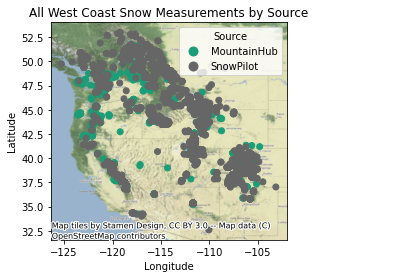

In [504]:
fig = plt.figure(figsize=(50, 40))
ax1 = df.plot(column = 'source',
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend  
    legend_kwds={
        # 'bbox_to_anchor': (0.6 , 0.8) , # push the legend off the map
        'title': 'Source' # Label the legend
        }, 
    )
# # Plot the Flight Boundaries (?)    
# flight_bound.plot(ax = ax1 ,
#     facecolor = 'none' ,
#     edgecolor = 'black')
ctx.add_basemap(ax1, # Add to the current axis
    crs=df.crs, # Assign the same CRS as the Dataframe
    source=ctx.providers.Stamen.TerrainBackground) # Determine what the base map is

# labels and titles
plt.title('All West Coast Snow Measurements by Source')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
# add the base map
ctx.add_basemap(ax1, crs=df.crs)


# Clean

## Clip to the boundaries

In [505]:
# add a site column to the dataframe
df["Site"] = np.nan
# re-order dataframe
df = df[['Site' , 'timestamp' , 'elevation' , 'depth'  , '_ms' , 'geometry' , 'source' , 'author' , 'id']]

# clip to the boundaries
df = gpd.clip(df , flight_bound) # clip the dataframe to the flight boundaries
df # Run a check of number of rows

# Assign a Site to each point
for index, row in df.iterrows(): # for the indices and rows 
    point = row["geometry"] # pull the geometry to test
    for num, ob in flight_bound.iterrows(): # for ever 
        if point.within(ob["geometry"]): 
            # print(ob["Name"]) 
            df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name

C:\Users\Owner\AppData\Local\Temp\ipykernel_18316\1976107789.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Site"][index] = ob["Name"]  # set the site label at theindex to the flight boundary name
c:\Users\Owner\anaconda3\envs\GDAL\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Plot it again

<Figure size 36000x36000 with 0 Axes>

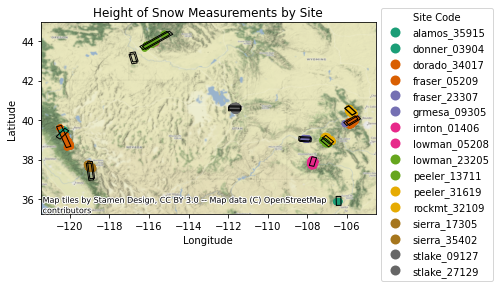

In [506]:
fig = plt.figure(figsize=(500, 500))
# Plot the points
ax1 = df.plot(column = 'Site' , # sorting by the site
    cmap = 'Dark2', # set the colormap 
    legend = True, # Turn on the legend
    legend_kwds={
        'bbox_to_anchor': (1, 1.1) , # push the legend off the map
        'title': 'Site Code' # Label the legend
        }, 
    )
# Plot the boundaries
flight_bound.plot(ax = ax1 , 
    facecolor = 'none' , # empty polygons 
    edgecolor = 'black') # determine the edge color
plt.title('Height of Snow Measurements by Site')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# add the base map
ctx.add_basemap(ax1, crs=df.crs)


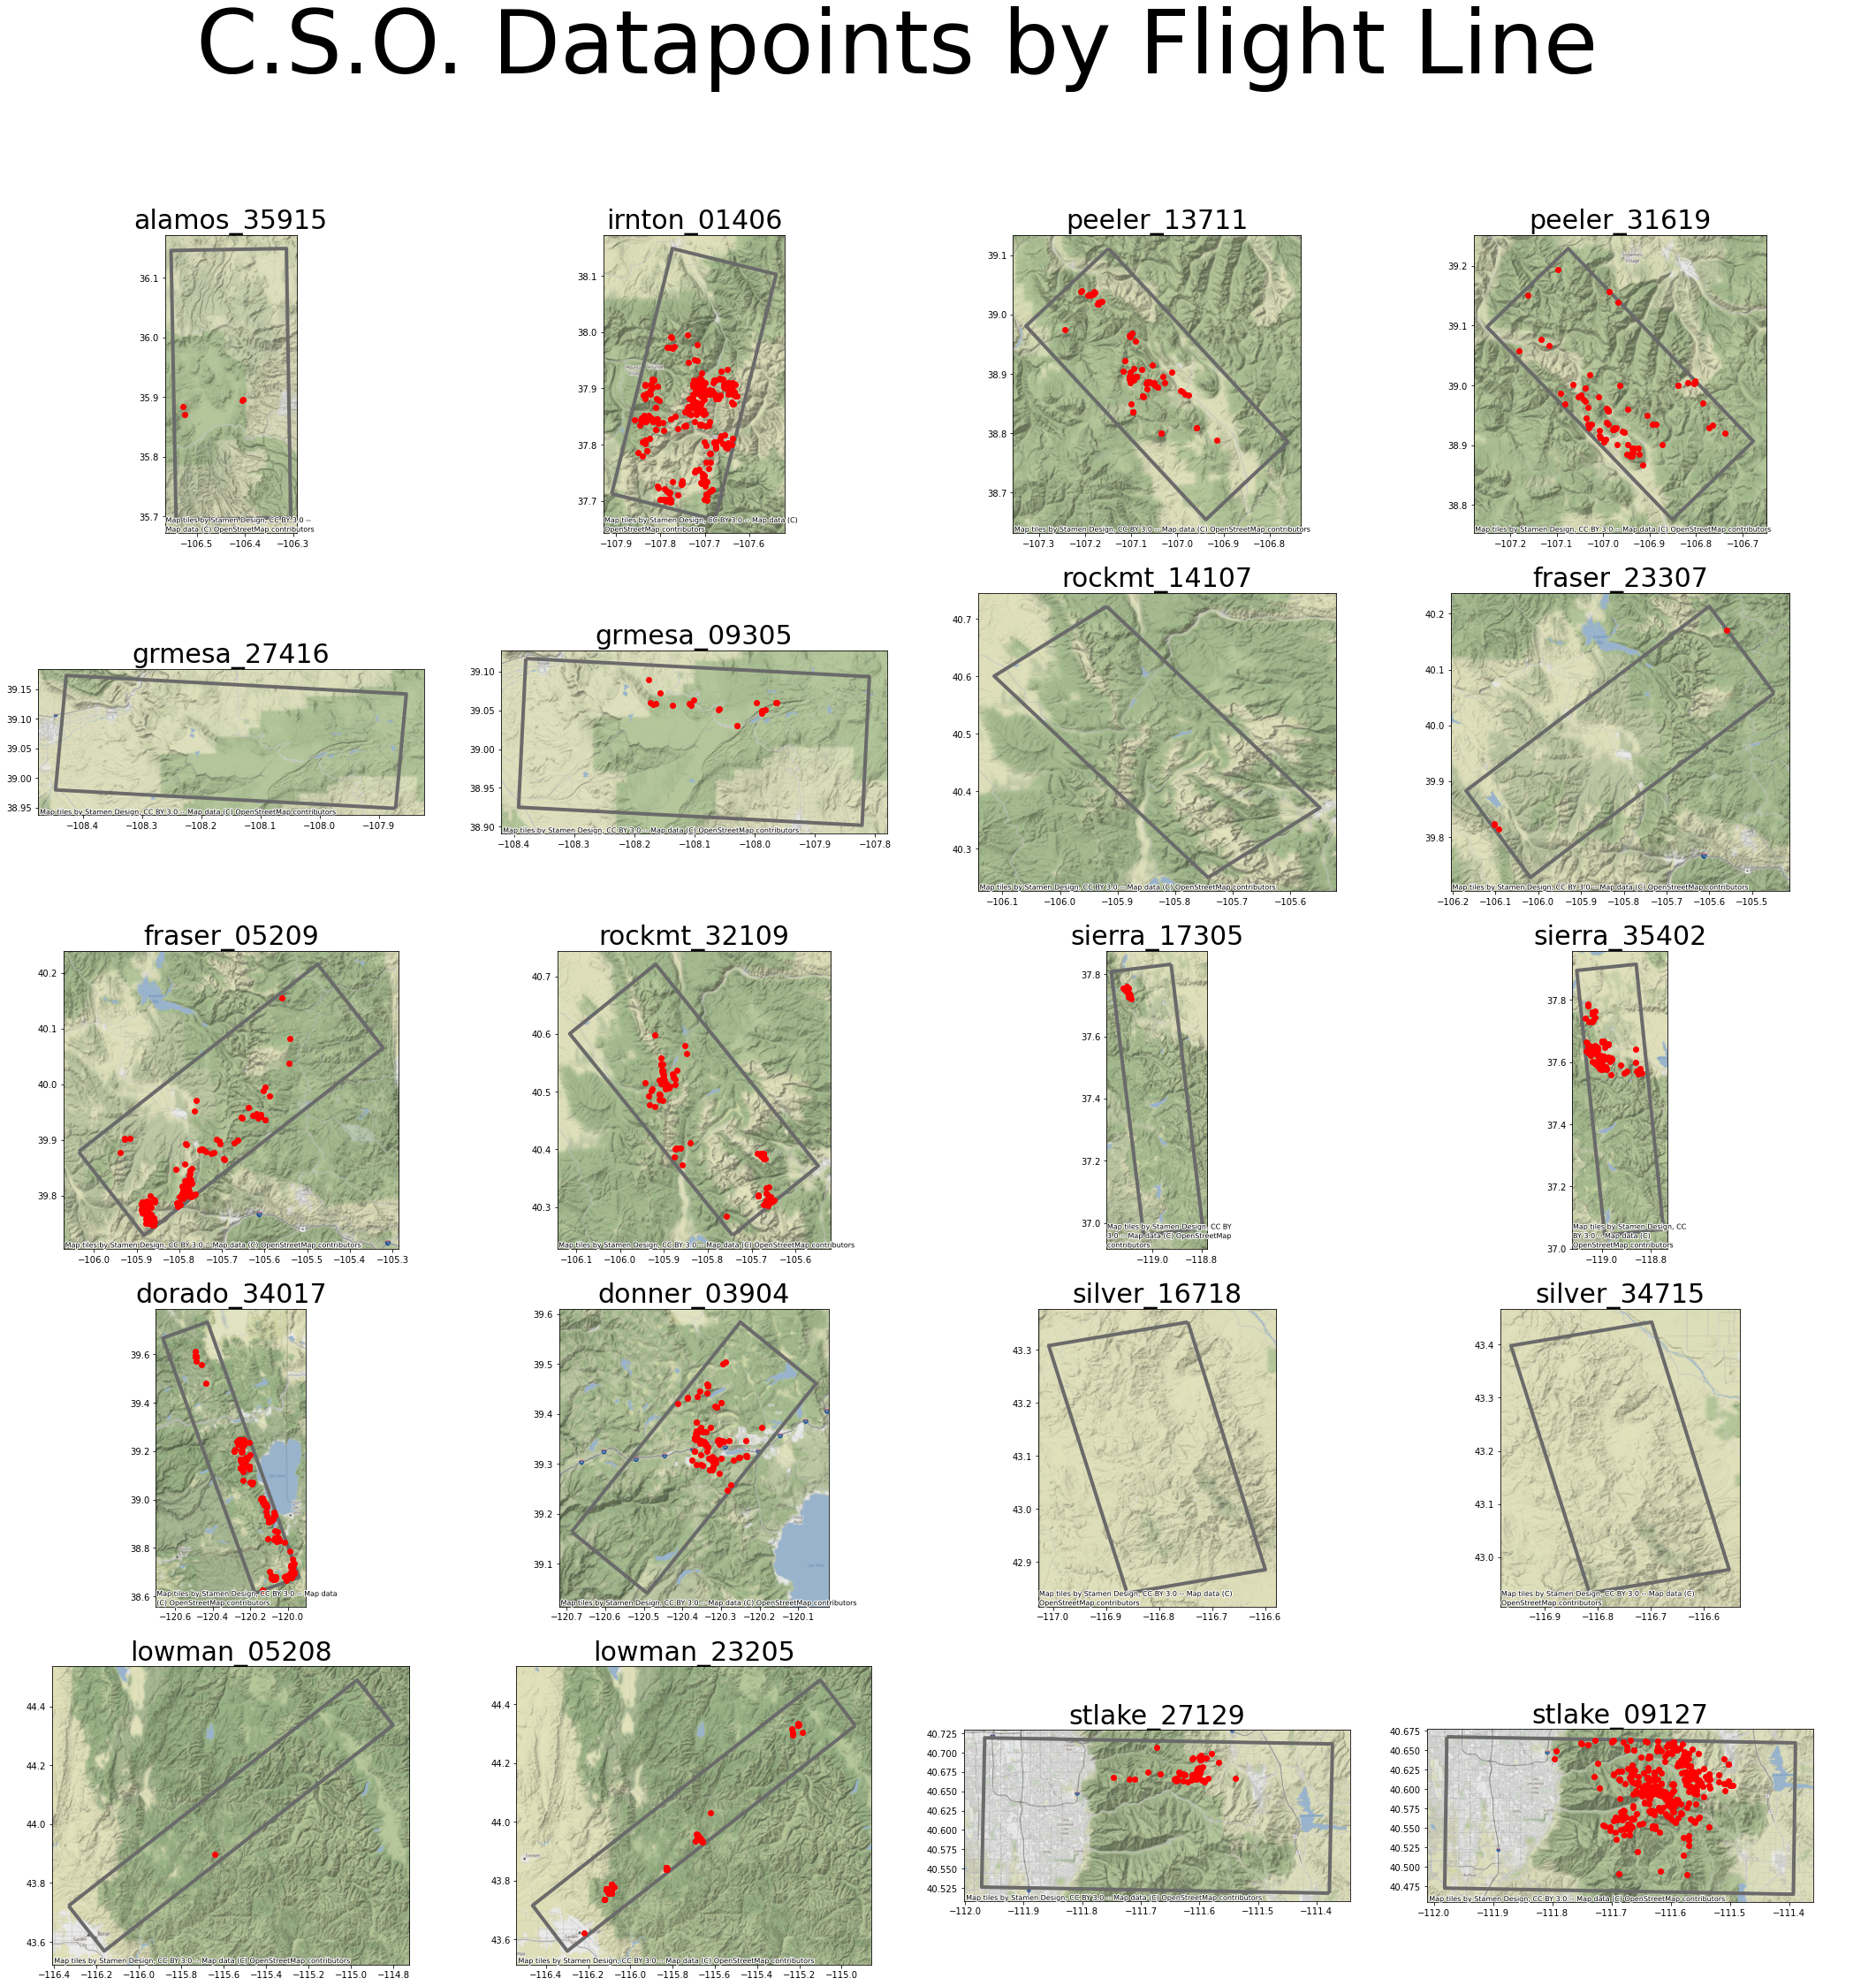

In [589]:
# ax1 = df.groupby('Site').plot(column = 'Site' )
# ctx.add_basemap(ax1, crs=df.crs)
# # # df
# name = flight_bound['Name'][0]
# fig, ax = plt.subplots(4,4, figsize = (40 , 40))
# df['site'][name]


fig, ax1 = plt.subplots(5, 4, figsize=(36, 36))
ax1 = ax1.flatten()

for idx in range(len(flight_bound)):

    # Plot the flight boundaries
    flight_bound.iloc[[idx]].plot(ax=ax1[idx], # plot it on the current figure axis (idx)
        facecolor = 'none', # make sure there is no fill
        edgecolor='#6a6a6a', # Turn the edges black
        linewidth= 4, # Line width
        )
     
    # Set the Title for the subplot
    ax1[idx].set_title(f"{flight_bound.iloc[idx]['Name']}", # Set the title to the Site
        fontsize = 30) # Set the font size

    # # Plot tthe base Map
    ctx.add_basemap(ax1[idx], 
      crs=df.crs) # set the crs to that of the dataframe
    

########################### Plot the Individual Points #######################3

    # skip the bad ones
    if flight_bound.iloc[idx]['Name'] == 'grmesa_27416':
        continue

    elif flight_bound.iloc[idx]['Name'] == 'rockmt_14107':
        continue

    elif flight_bound.iloc[idx]['Name'] == 'silver_16718':
        continue

    elif flight_bound.iloc[idx]['Name'] == 'silver_34715':
        continue
    else:

    
        # else plot the new ones
        dnew = df[df['Site'] == flight_bound['Name'][idx] ]
        dnew.plot(ax=ax1[idx] ,
            color = 'red')

plt.suptitle('C.S.O. Datapoints by Flight Line',  # Set the overall title
    fontsize = 100) # Fontsize
plt.show()